% WARM UP

In [ ]:
print("Hello World!")

Hello World


In [17]:
def greet():
    print('Hello World! Welcome to Notebooks!')
    
greet()

Hello World! Welcome to Notebooks!


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


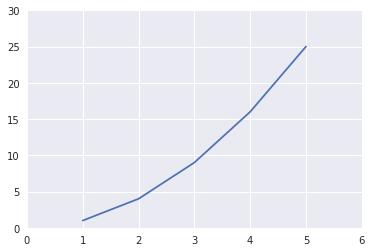

In [32]:
import matplotlib.pyplot as pl
pl.plot([1,2,3,4,5], [1,4,9,16,25])
pl.axis([0,6,0,30])
pl.show()

Sample BigQuery Command

In [ ]:
%%bq query
SELECT name,  gender,  SUM(number) AS total FROM  `bigquery-public-data.usa_names.usa_1910_2013`
GROUP BY  name,  gender
ORDER BY  total DESC
LIMIT  10

Sample BigQuery call within Python(3) Script 

In [39]:
from google.cloud import bigquery
client = bigquery.Client()

query = ("""SELECT  name, gender,  SUM(number) AS total FROM  `bigquery-public-data.usa_names.usa_1910_2013`
         GROUP BY  name, gender
         ORDER BY  total DESC
         LIMIT  10""")

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location='US')  # API request - starts the query

In [40]:
for row in query_job:  # API request - fetches results
    # Row values can be accessed by field name or index
    assert row[0] == row.name == row['name']
    print(row)

Row(('James', 'M', 4924235), {'name': 0, 'gender': 1, 'total': 2})
Row(('John', 'M', 4818746), {'name': 0, 'gender': 1, 'total': 2})
Row(('Robert', 'M', 4703680), {'name': 0, 'gender': 1, 'total': 2})
Row(('Michael', 'M', 4280040), {'name': 0, 'gender': 1, 'total': 2})
Row(('William', 'M', 3811998), {'name': 0, 'gender': 1, 'total': 2})
Row(('Mary', 'F', 3728041), {'name': 0, 'gender': 1, 'total': 2})
Row(('David', 'M', 3541625), {'name': 0, 'gender': 1, 'total': 2})
Row(('Richard', 'M', 2526927), {'name': 0, 'gender': 1, 'total': 2})
Row(('Joseph', 'M', 2467298), {'name': 0, 'gender': 1, 'total': 2})
Row(('Charles', 'M', 2237170), {'name': 0, 'gender': 1, 'total': 2})


Visualization with Datalab using Python and Pandas
The data is natality data (record of births in the US). Goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother. Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that.

In [41]:
query="""
SELECT  weight_pounds,  is_male,  mother_age,  plurality,  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,6.686620,False,35,1,35,-1525201076796226340
1,5.937049,False,32,1,35,1088037545023002395
2,7.063611,False,28,1,35,-1403073183891835564
3,6.124442,False,37,1,36,6691862025345277042
4,5.000084,False,35,2,36,6392072535155213407


Let's write a query to find the unique values for each of the columns and the count of those values.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


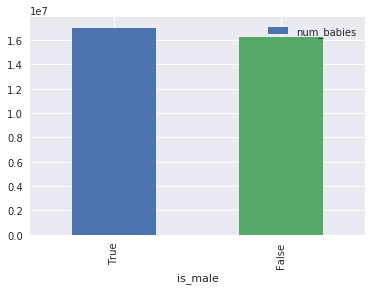

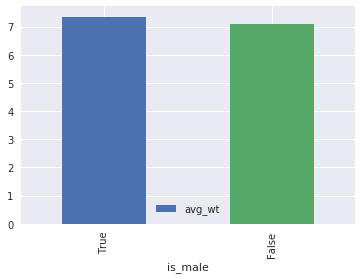

In [42]:
def get_distinct_values(column_name):
    sql = """
SELECT  {0},  COUNT(1) AS num_babies,  AVG(weight_pounds) AS avg_wt
FROM    publicdata.samples.natality
WHERE   year > 2000
GROUP BY  {0}    """.format(column_name)
    return bq.Query(sql).execute().result().to_dataframe()
df = get_distinct_values('is_male')
df.plot(x='is_male', y='num_babies', kind='bar');
df.plot(x='is_male', y='avg_wt', kind='bar');

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


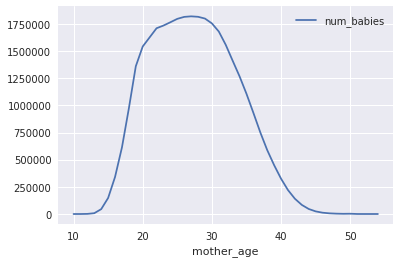

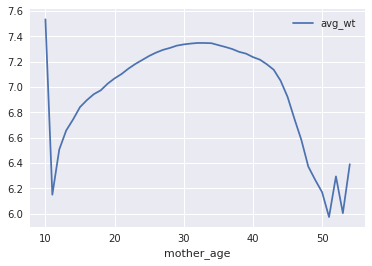

In [43]:
df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x='mother_age', y='num_babies');
df.plot(x='mother_age', y='avg_wt');

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


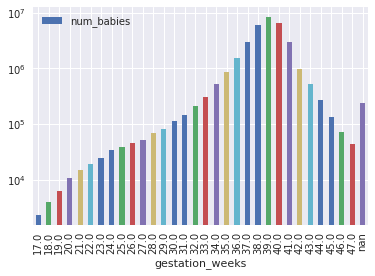

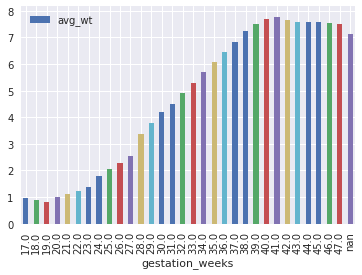

In [44]:
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', y='num_babies', logy=True, kind='bar');
df.plot(x='gestation_weeks', y='avg_wt', kind='bar');

In [ ]:
Create a Linear Regression Model to Predict Birth weight using  BigQuery

In [45]:
%%bq query
#standardSQL
CREATE OR REPLACE MODEL  `bqml_tutorial.natality_model`
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['weight_pounds']) AS
SELECT  weight_pounds,  is_male,  gestation_weeks,  mother_age,
  CAST(mother_race AS string) AS mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND RAND() < 0.001

QueryResultsTable job_PEqLerU3L_5Nvh9ioePcYRxFHuNs

Model evaludation using  BigQuery

In [3]:
%%bq query
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.natality_model`,
    (
    SELECT      weight_pounds,      is_male,      gestation_weeks,      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      weight_pounds IS NOT NULL))

mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0.9549077095427253,1.6782848627735483,0.03443807543454127,0.7352816429195936,0.0449984366347006,0.04542803742005974


Prediction of Birth Weight for the State of Wyoming using  BigQuery

In [5]:
%%bq query
#standardSQL
SELECT
  predicted_weight_pounds
FROM
  ML.PREDICT(MODEL `bqml_tutorial.natality_model`,
    (
    SELECT      is_male,      gestation_weeks,      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      state = "WY"))

predicted_weight_pounds
7.600125782017585
7.600125782017585
7.600125782017585
7.600125782017585
7.600125782017585
7.600125782017585
7.600125782017585
7.600125782017585
7.600125782017585
7.600125782017585
